In [2]:
import numpy as np
import cv2
from scipy.spatial.distance import squareform, pdist, cdist
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt

####Hough transform

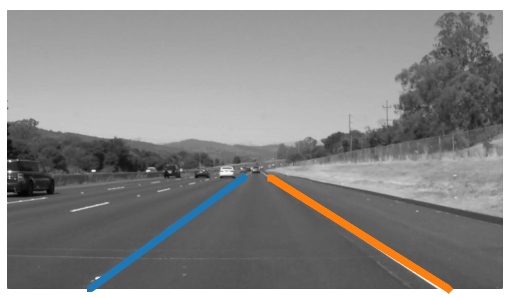

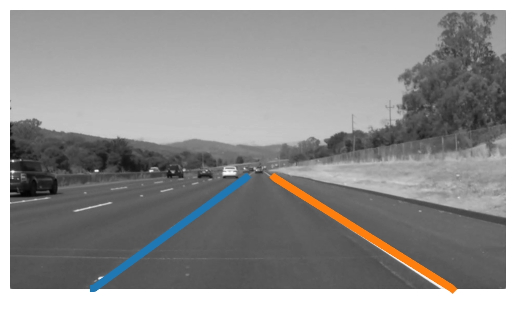

In [3]:
def hough_transform(img):
    """ Transform points in the input image into Hough space.

    Use the parameterization:
        rho = x * cos(theta) + y * sin(theta)
    to transform a point (x,y) to a sine-like function in Hough space.

    Args:
        img: binary image of shape (H, W).

    Returns:
        accumulator: numpy array of shape (m, n).
        rhos: numpy array of shape (m, ).
        thetas: numpy array of shape (n, ).
    """
    # Set rho and theta ranges
    W, H = img.shape
    diag_len = int(np.ceil(np.sqrt(W * W + H * H)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2 + 1)
    thetas = np.deg2rad(np.arange(-90.0, 90.0))

    # Cache some reusable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Initialize accumulator in the Hough space
    accumulator = np.zeros((2 * diag_len + 1, num_thetas), dtype=np.uint64)
    ys, xs = np.nonzero(img)

    # Transform each point (x, y) in image
    # Find rho corresponding to values in thetas
    # and increment the accumulator in the corresponding coordiate.
    ### YOUR CODE HERE
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    for x, y in zip(xs, ys):
        for t_idx in range(num_thetas):
            rho = int(round(x*cos_t[t_idx]) + y*sin_t[t_idx]) + diag_len
            accumulator[rho, t_idx] += 1

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ### END YOUR CODE

    return accumulator, rhos, thetas

# Load gray-scale image, img=
img = cv2.imread('road.jpg', 0)
# Run edge detection using cv2.canny, edges=
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

edges = cv2.Canny(img, 50, 100, L2gradient=True)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
### END YOUR CODE

# Extract ROI
H, W = img.shape

# Generate mask for ROI (Region of Interest)
mask = np.zeros((H, W))
for i in range(H):
    for j in range(W):
        if i > (H / W) * j and i > -(H / W) * j + H:
            mask[i, j] = 1

# Extract edges in ROI
roi = edges * mask

# Perform Hough transform on the ROI
acc, rhos, thetas = hough_transform(roi)

# Coordinates for right lane
xs_right = []
ys_right = []

# Coordinates for left lane
xs_left = []
ys_left = []

for i in range(20):
    idx = np.argmax(acc)
    r_idx = idx // acc.shape[1]
    t_idx = idx % acc.shape[1]
    acc[r_idx, t_idx] = 0 # Zero out the max value in accumulator

    rho = rhos[r_idx]
    theta = thetas[t_idx]

    # Transform a point in Hough space to a line in xy-space.
    a = - (np.cos(theta)/np.sin(theta)) # slope of the line
    b = (rho/np.sin(theta)) # y-intersect of the line

    # Break if both right and left lanes are detected
    if xs_right and xs_left:
        break

    if a < 0: # Left lane
        if xs_left:
            continue
        xs = xs_left
        ys = ys_left
    else: # Right Lane
        if xs_right:
            continue
        xs = xs_right
        ys = ys_right

    for x in range(img.shape[1]):
        y = a * x + b
        if y > img.shape[0] * 0.6 and y < img.shape[0]:
            xs.append(x)
            ys.append(int(round(y)))

plt.imshow(img, cmap='gray')
plt.plot(xs_left, ys_left, linewidth=5.0)
plt.plot(xs_right, ys_right, linewidth=5.0)
plt.axis('off')
plt.show()